In [7]:
import numpy as np
from matplotlib import pyplot as plt
import SimpleITK as sitk
import pickle as pkl

import cv2
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import SimpleITK as sitk
import pickle as pkl

import cv2
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Visualize registration result

In [ ]:

import pickle as pkl
from cv2 import cvtColor

def to_grayscale(img):
    original_shape = img.shape[:2]
    img = cvtColor(img,cv2.COLOR_BGR2GRAY).astype(float)
    img /= np.max(img)
    return img
def centroid3(img):
    nx, ny, nz = img.shape
    # print(nx,ny,nz)
    imgx = np.sum(np.sum(img, axis=1), axis=1)
    imgy = np.sum(np.sum(img, axis=2), axis=0)
    imgz = np.sum(np.sum(img, axis=0), axis=0)
    denom = np.sum(np.sum(np.sum(img, axis=0), axis=0), axis=0)
    cx = np.sum(np.linspace(0, nx-1, nx)*imgx)/denom
    cy = np.sum(np.linspace(0, ny-1, ny)*imgy)/denom
    cz = np.sum(np.linspace(0, nz-1, nz)*imgz)/denom
    
    return cx, cy, cz

def plot_img_at(img, coord, label='Target Location',
    vmin = 0.4,
    vmax = 0.8,ax=None):
    '''
        Plot the 3D slicing view of img at coord.
    '''
    img = np.array(img)
    img += -np.min(img)
    img /= np.max(img)
   
    l,p,s = coord
    
    
    target_marker = 'x'
    target_size = 50
    target_color = 'yellow'

  
    if ax is None:
        ax = plt.gca()
    ax.axis('off')
    
    # Only plot the horizontal slice.
    ax.imshow(np.squeeze(img[:,:,s]).T,cmap='gray',vmin=vmin,vmax=vmax)
    ax.scatter(l,p,marker = target_marker,s=target_size,color = target_color,label=label)
    ax.legend()    
    return ax
def visualize_body(img,target_pixel=None,label=None,
                    vmin = 0.4,
                    vmax = 0.8,ax=None):
    img = sitk.GetArrayViewFromImage(img).astype(float)
    img = np.swapaxes(img,0,2)
    if target_pixel is None:
        target_pixel = np.array(centroid3(img))
        label = 'Centroid location'
    plot_img_at(img,np.array(target_pixel,dtype=int),label,vmin,vmax,ax)
    
    
def flip_img(input_img,orders):
    flipped_ct = sitk.Flip(input_img,orders)
    flipped_ct = sitk.GetImageFromArray(sitk.GetArrayFromImage(flipped_ct).astype(np.float64))
    flipped_ct.SetOrigin(input_img.GetOrigin())
    flipped_ct.SetSpacing(input_img.GetSpacing())
    return flipped_ct

In [ ]:
with open('us_observations.pkl','rb') as fp:
    data = pkl.load(fp)
target_locs = data['CT_target_locs']
origin = data['Observation Origin']
frames = data['frame']
body_ct = sitk.ReadImage('./nifty/CT_phantom_regular.nii.gz')
body_ct = flip_img(body_ct,[True,False,False])

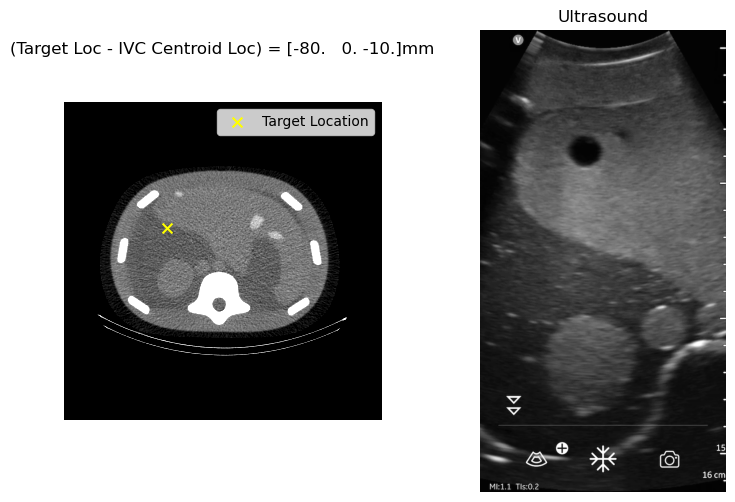

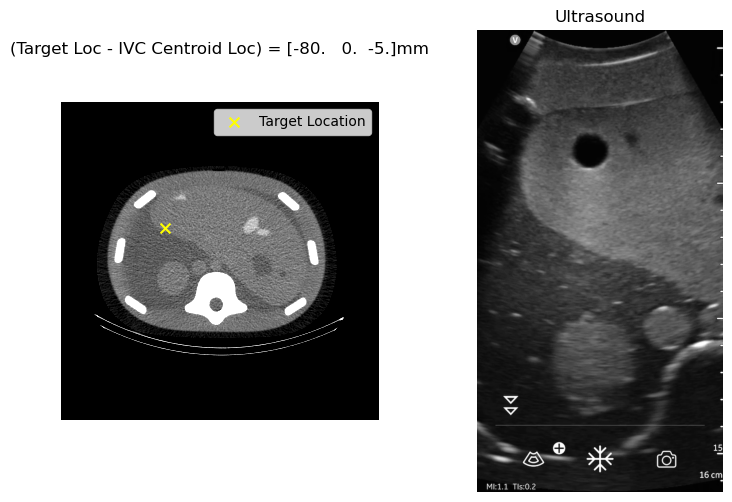

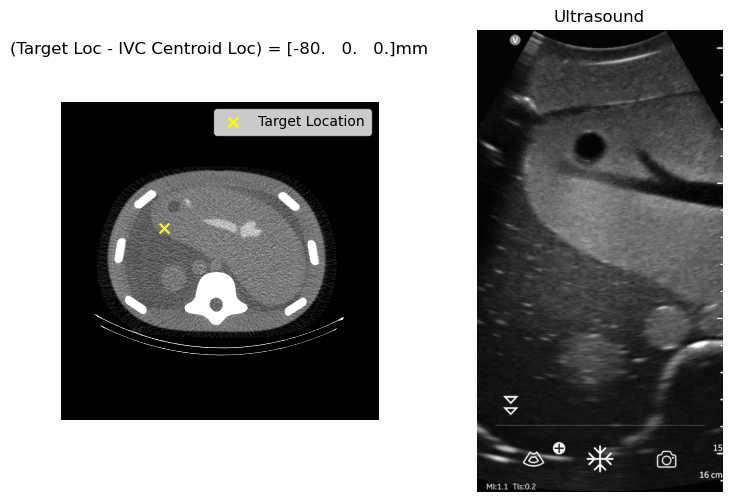

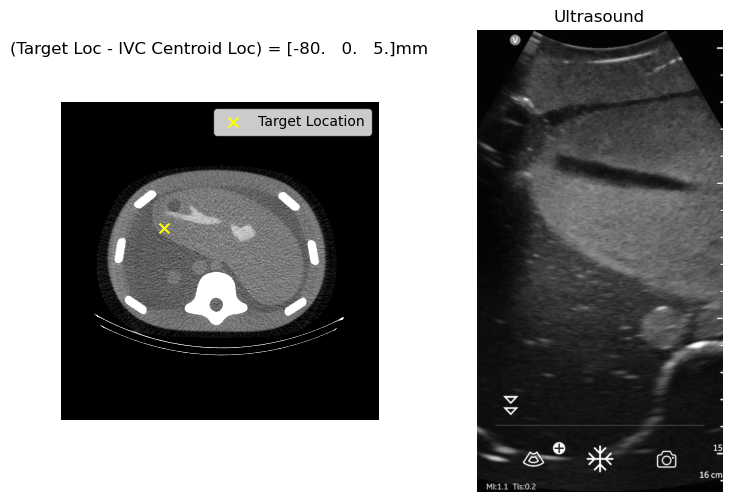

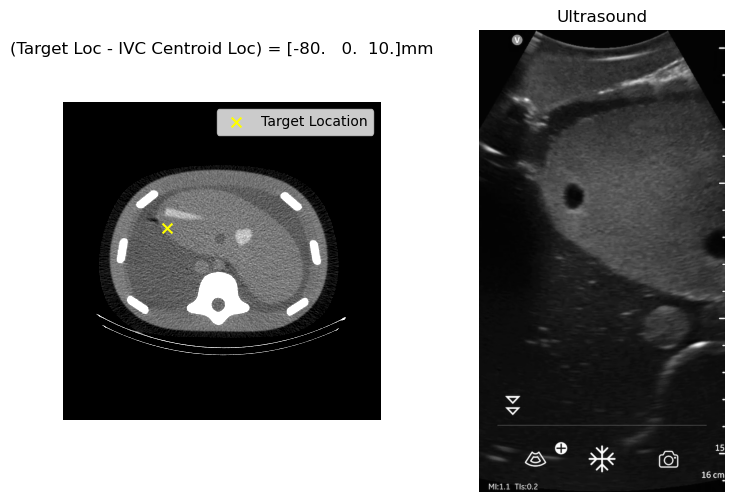

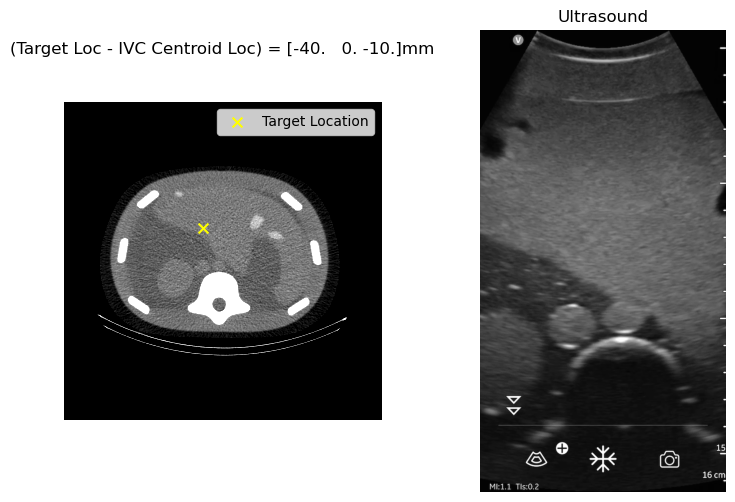

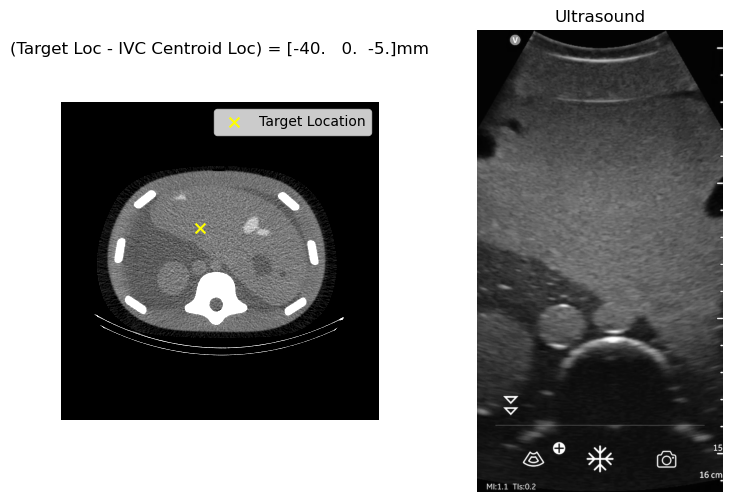

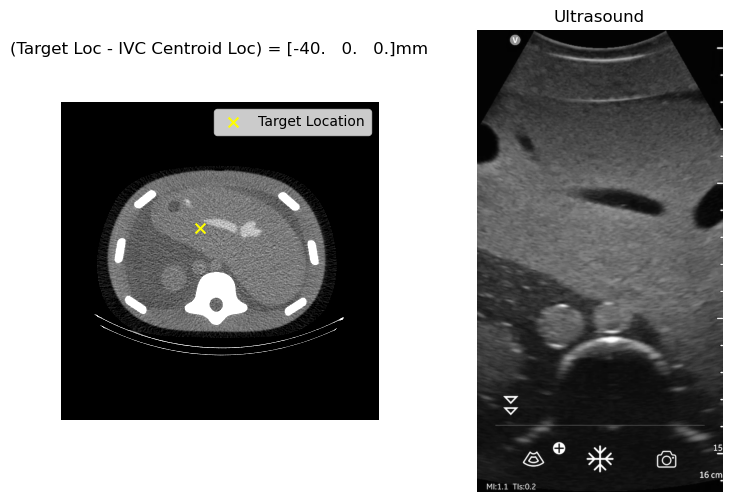

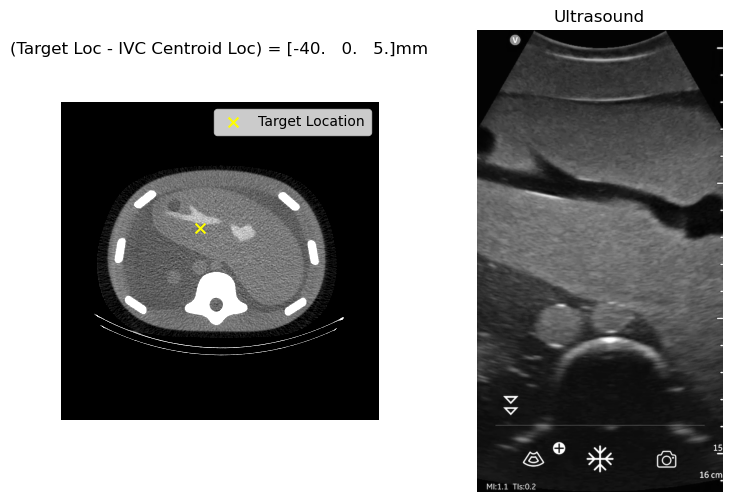

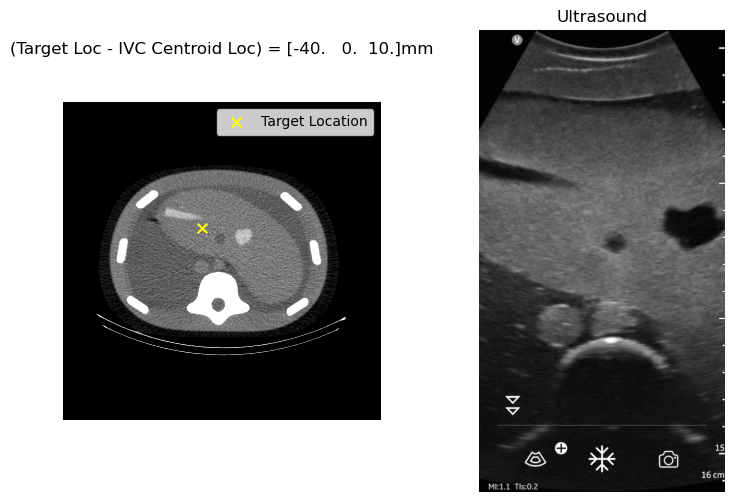

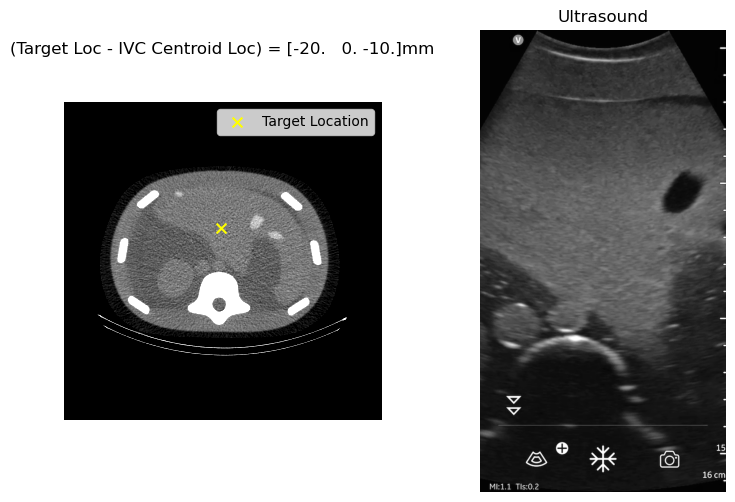

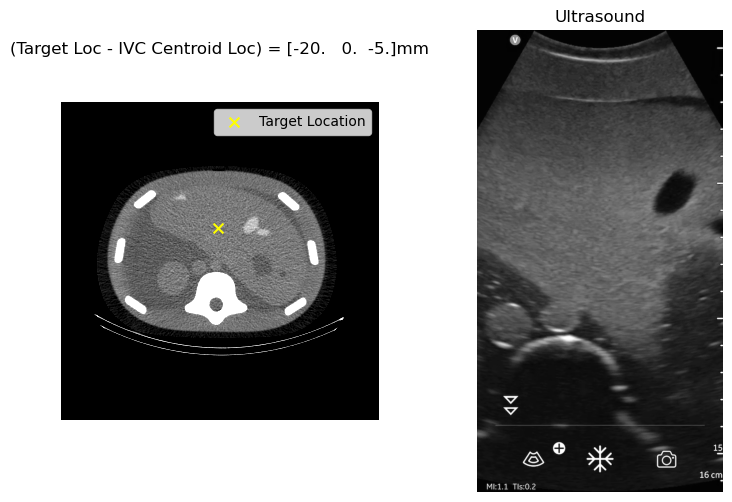

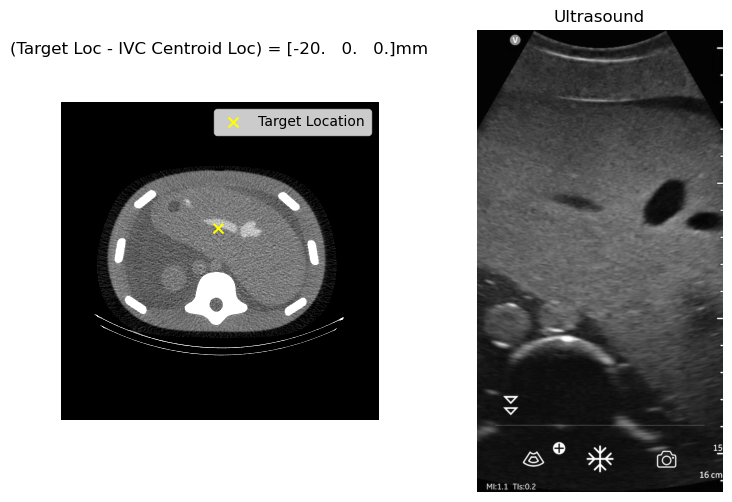

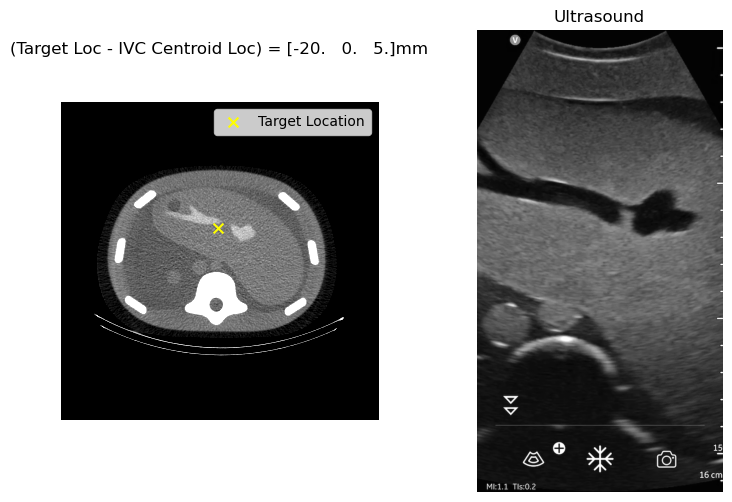

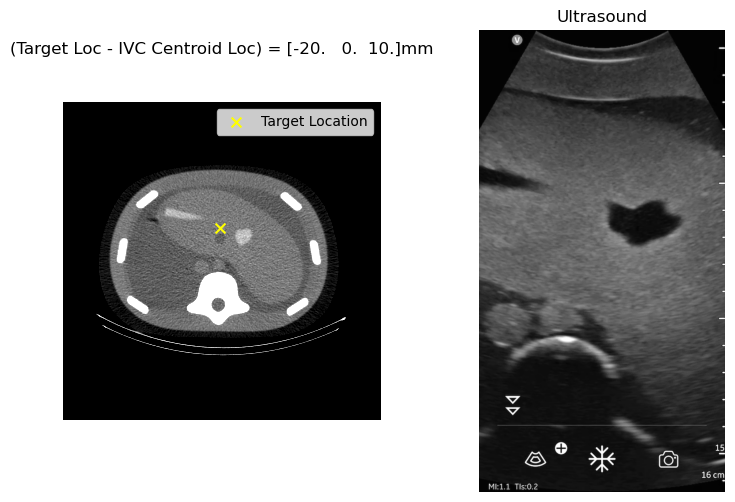

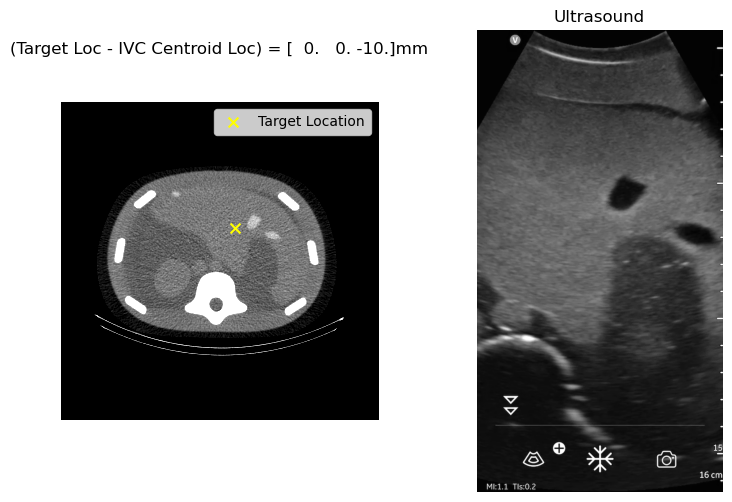

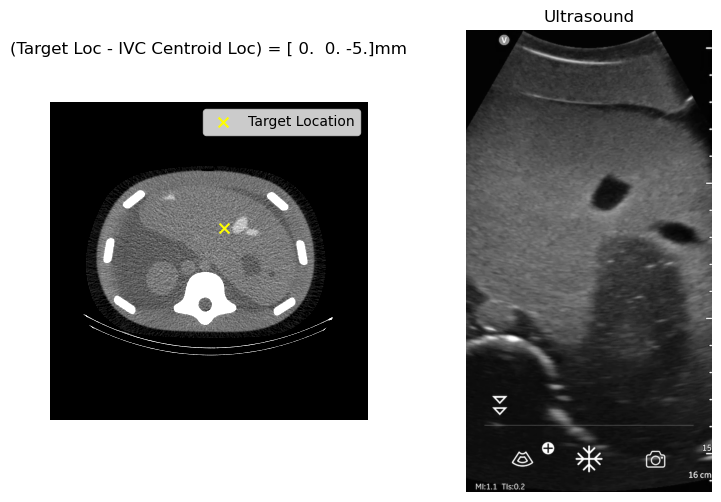

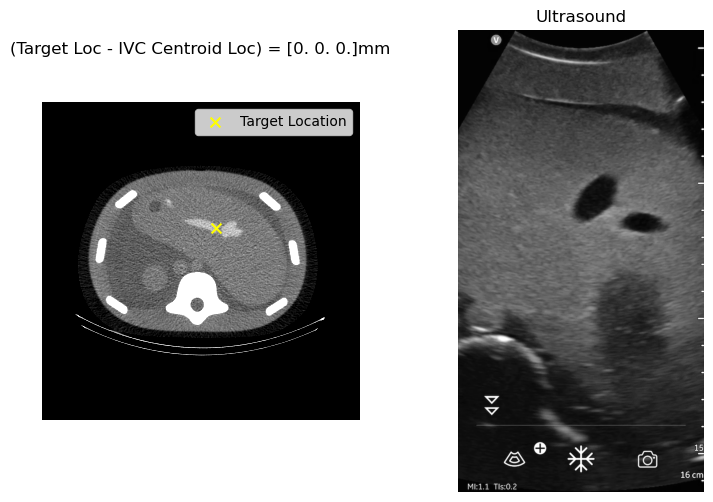

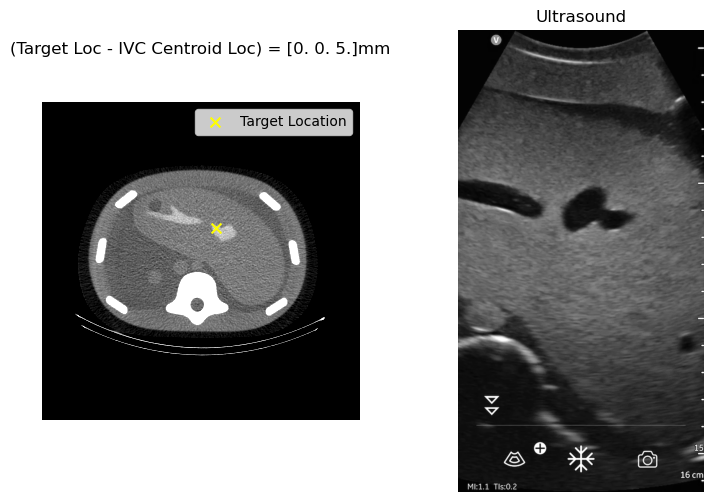

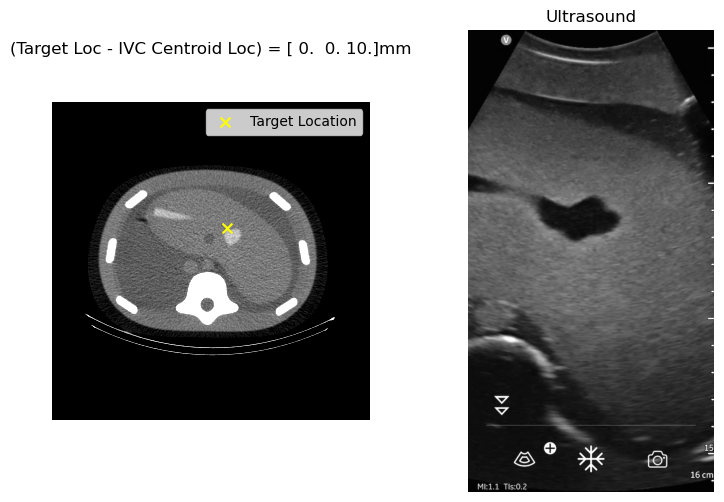

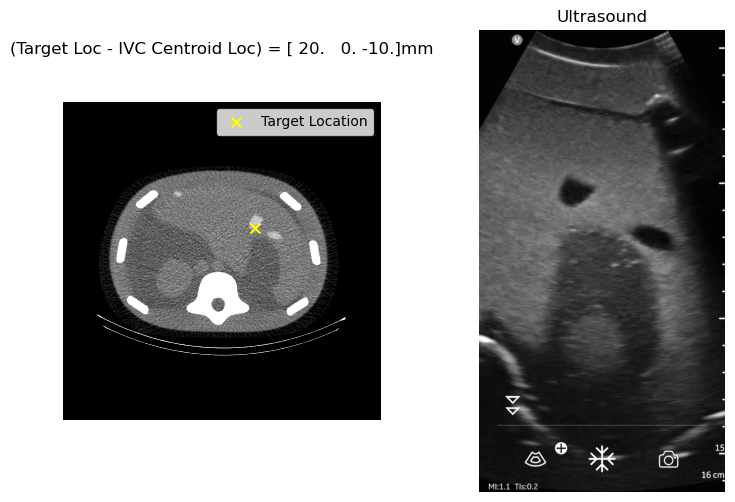

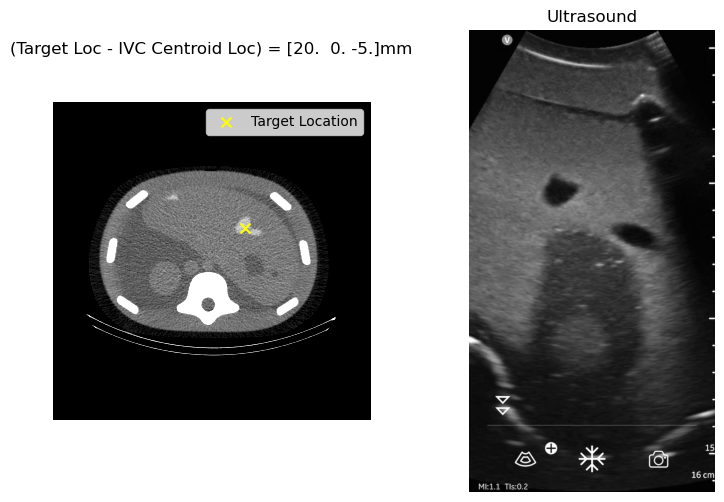

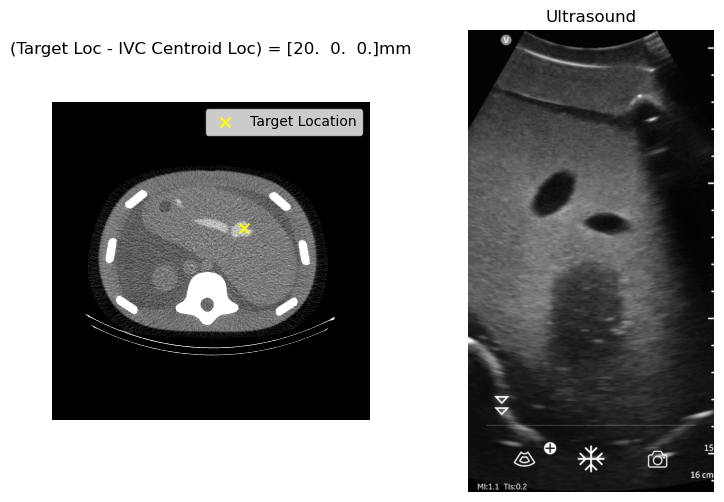

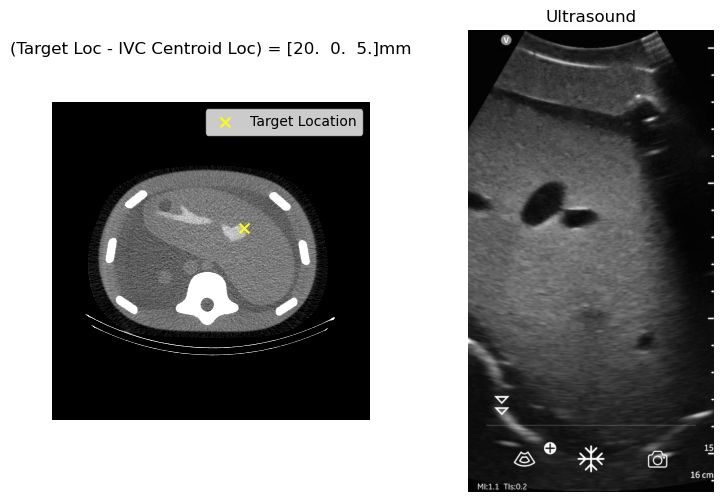

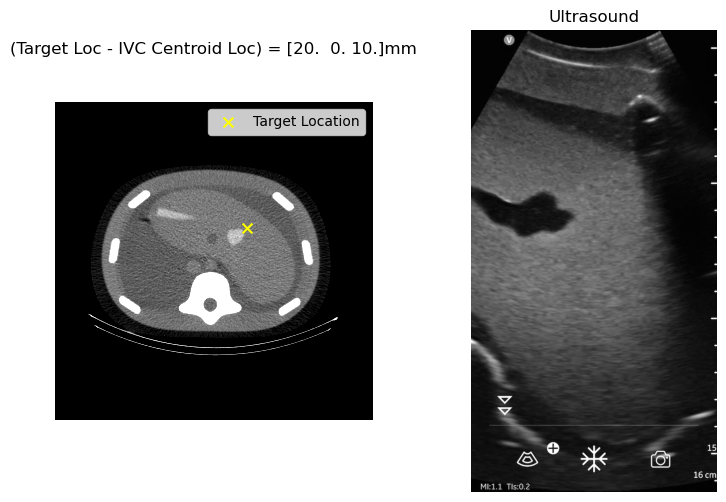

In [59]:
from scripts.Registration3D.registration import visualize_vessel,get_centroid_loc

# x_cand = [-80,-40,-20,0,20]
# z_cand = [-10,-5,0,5,10]

i = 0
for loc,frame in zip(target_locs[:],frames[:]):
    plt.figure(figsize=(9,6))
    
    pix = body_ct.TransformPhysicalPointToIndex(loc)
    # visualize_vessel(original_vessel_ct,pix,'Target Location')
    ax = plt.subplot(1,2,1)
    visualize_body(body_ct,pix,'Target Location',vmin=0.6,vmax=0.8,ax=ax)
    ax.set_title('(Target Loc - IVC Centroid Loc) = {}mm'.format(loc-origin))

    ax = plt.subplot(1,2,2)
    ax.axis('off')
    ax.imshow(to_grayscale(frame[100:1040]),cmap = 'gray')
    ax.set_title('Ultrasound')
    plt.savefig('./figures/{}.png'.format(i))
    plt.show()
    i+=1
